In [1]:
DATE = "2021-08-23"
TASK = "iterative-correction"
DIR = mkpath("$(homedir())/$(DATE)-$(TASK)")

"/home/jovyan/2021-08-23"

In [2]:
import Pkg
pkgs = [
#     "BioAlignments",
    "BioSequences",
#     "Clustering",
#     "CodecZlib",
#     "Colors",
#     "Combinatorics",
#     "DataFrames",
#     "DataStructures",
    "Dates",
#     "DelimitedFiles",
#     "Distances",
#     "EzXML",
    "FASTX",
#     "GFF3",
#     "HTTP",
#     "Impute",
#     "JSON",
    "Graphs",
    "LSHFunctions",
#     "Measures",
    "MetaGraphs",
    "https://github.com/cjprybol/Mycelia.git",
#     "NumericIO",
#     "PlotlyJS",
#     "Plots",
    "Primes",
#     "Printf",
    "ProgressMeter",
    "Random",
    "Revise",
    "SparseArrays",
    "Statistics",
    "StatsBase",
#     "StatsPlots",
#     "StringDistances",
#     "uCSV",
#     "XLSX",
]

unregistered_packages = filter(pkg -> occursin(r"(^https|git$)", pkg), pkgs)
registered_packages = setdiff(pkgs, unregistered_packages)

for pkg in registered_packages
    try
        eval(Meta.parse("import $(pkg)"))
    catch
        Pkg.add(pkg)
        Pkg.build(pkg)
        eval(Meta.parse("import $(pkg)"))
    end
end

for pkg_url in unregistered_packages
    pkg_name = replace(basename(pkg_url), ".git" => "")
    try
        eval(Meta.parse("import $(pkg_name)"))
    catch
        Pkg.develop(url=pkg_url)
        Pkg.build(pkg_name)
        eval(Meta.parse("import $(pkg_name)"))
    end
end

In [3]:
if Sys.isapple()
    BANDAGE = "/Applications/Bandage.app/Contents/MacOS/Bandage"
else
    BANDAGE = "Bandage"
end

"Bandage"

In [4]:
function assess_kmer_sparsity_in_reads(k, observations)
#     @show k, observations
    canonical_kmer_counts = Mycelia.count_canonical_kmers(BioSequences.DNAMer{k}, observations)
#     canonical_kmer_counts = Mycelia.count_canonical_kmers(BioSequences.DNAMer{k}, first(observations))
# #     @show canonical_kmer_counts
#     for i in 2:length(observations)
#         canonical_kmer_counts_ = Mycelia.count_canonical_kmers(BioSequences.DNAMer{k}, observations[i])
#         canonical_kmer_counts = merge!(+, canonical_kmer_counts, canonical_kmer_counts_)
#     end
#     canonical_kmer_counts = map(o -> Mycelia.count_canonical_kmers(BioSequences.DNAMer{k}, o), observations)...)
    total_observed_canonical_kmers = length(keys(canonical_kmer_counts))
    total_possible_canonical_kmers = (4^k)/2
    sparsity = round(total_observed_canonical_kmers/total_possible_canonical_kmers*100, digits=2)
    @show sparsity
    return sparsity
end

assess_kmer_sparsity_in_reads (generic function with 1 method)

In [5]:
function sequence_to_canonical_kmers(kmer_type, sequence)
    return (BioSequences.canonical(kmer.fw) for kmer in BioSequences.each(kmer_type, sequence))
end

sequence_to_canonical_kmers (generic function with 1 method)

In [6]:
function determine_edge_weights(graph)
    outgoing_edge_probabilities = determine_edge_weights(graph, true)
    incoming_edge_probabilities = determine_edge_weights(graph, false)
    return Dict(true => outgoing_edge_probabilities, false => incoming_edge_probabilities)
end

determine_edge_weights (generic function with 1 method)

In [7]:
function determine_edge_weights(graph, strand)
    kmers = [graph.vprops[v][:kmer] for v in Graphs.vertices(graph)]
    outgoing_edge_weights = SparseArrays.spzeros(length(kmers), length(kmers))
    
    for (kmer_index, kmer) in enumerate(kmers)
        if !strand
            kmer = BioSequences.reverse_complement(kmer)
        end
        
        downstream_neighbors = []
        downstream_neighbor_weights = []
        for neighbor in BioSequences.neighbors(kmer)
            canonical_neighbor = BioSequences.canonical(neighbor)
            neighbor_orientation = neighbor == canonical_neighbor
            
            neighbor_index_range = searchsorted(kmers, canonical_neighbor)
            if !isempty(neighbor_index_range)
                @assert length(neighbor_index_range) == 1
                neighbor_index = first(neighbor_index_range)
                if Graphs.has_edge(graph, Graphs.Edge(kmer_index, neighbor_index))
                    edge_orientations = graph.eprops[Graphs.Edge(kmer_index, neighbor_index)][:orientations]
                    this_edge_orientation = (source_orientation = strand, destination_orientation = neighbor_orientation)
                    if this_edge_orientation in edge_orientations
                        edge_weight = graph.eprops[Graphs.Edge(kmer_index, neighbor_index)][:weight]
                        outgoing_edge_weights[kmer_index, neighbor_index] = edge_weight
                    end
                end
            end
        end
    end
    return outgoing_edge_weights
end

determine_edge_weights (generic function with 2 methods)

In [8]:
function determine_edge_probabilities(edge_weights)
    edge_probabilities = deepcopy(edge_weights)
    for orientation in [true, false]
        for row in 1:size(edge_probabilities[orientation], 1)
            edge_weights = edge_probabilities[orientation][row, :]
            edge_total = sum(edge_weights)
            for (col, edge_weight) in enumerate(edge_weights)
                if edge_total > 0
                    edge_probabilities[orientation][row, col] = edge_weight/edge_total
                else
                    edge_probabilities[orientation][row, col] = 0.0
                end
            end
        end
    end
    return edge_probabilities
end

determine_edge_probabilities (generic function with 1 method)

In [9]:
function random_step(current_vertex, current_orientation, step_probabilities)
    outgoing_edge_likelihoods = step_probabilities[initial_orientation][current_vertex, :]
    chosen_step = StatsBase.sample(outgoing_edge_likelihoods.nzind, StatsBase.weights(outgoing_edge_likelihoods.nzval))
    possible_orientations = observation_graph.eprops[Graphs.Edge(current_vertex, chosen_step)][:orientations]
    possible_orientations = filter(o -> o.source_orientation == current_orientation, possible_orientations)
    chosen_orientation = rand(possible_orientations).destination_orientation
    chosen_oriented_step = (vertex = chosen_step, orientation = chosen_orientation)
    return chosen_oriented_step
end

random_step (generic function with 1 method)

In [10]:
function random_walk(observation_graph, initial_vertex, initial_orientation, step_probabilities; n_steps=size(step_probabilities[true], 1))
    step_count = 0
    outgoing_edge_likelihoods = step_probabilities[initial_orientation][initial_vertex, :]
    walk = Vector{NamedTuple{(:vertex, :orientation), Tuple{Int64, Bool}}}()
    done = (step_count > n_steps) || (sum(outgoing_edge_likelihoods) == 0)
    current_vertex = initial_vertex
    current_orientation = initial_orientation
    while !done
#         @show "choosing"
        chosen_step = StatsBase.sample(outgoing_edge_likelihoods.nzind, StatsBase.weights(outgoing_edge_likelihoods.nzval))
        chosen_step
        possible_orientations = observation_graph.eprops[Graphs.Edge(current_vertex, chosen_step)][:orientations]
        possible_orientations
        current_orientation
        possible_orientations = filter(o -> o.source_orientation == current_orientation, possible_orientations)
        possible_orientations
        chosen_orientation = rand(possible_orientations).destination_orientation
        chosen_oriented_step = (vertex = chosen_step, orientation = chosen_orientation)
        push!(walk, chosen_oriented_step)
        current_vertex = chosen_step
        current_orientation = chosen_orientation
        outgoing_edge_likelihoods = step_probabilities[last(walk).orientation][last(walk).vertex, :]
        step_count += 1
#         @show outgoing_edge_likelihoods
        done = (step_count > n_steps) || (sum(outgoing_edge_likelihoods) == 0)
    end
    return walk
end

random_walk (generic function with 1 method)

In [11]:
# generate a genome
sequence_length = 100
sequence = BioSequences.randdnaseq(Random.seed!(sequence_length), sequence_length)
sequence_id = string(hash(sequence))
fasta_record = FASTX.FASTA.Record(sequence_id, sequence)

FASTX.FASTA.Record:
   identifier: 3157291459485254640
  description: <missing>
     sequence: CTCACTGCAAAGCGCCCAGACCAGAGCCTCACCTACAAG…

In [12]:
reference_fasta_file = "$(DIR)/LENGTH-$(sequence_length).fasta"
open(reference_fasta_file, "w") do io
    fastx_io = FASTX.FASTA.Writer(io)
    write(fastx_io, fasta_record)
    close(fastx_io)
end

In [13]:
# randomly sample reads with errors from the genome
# 1%
error_rate = 0.01
n_reads = 100 * sequence_length

# observations = [Mycelia.observe(FASTX.sequence(record), error_rate = error_rate) for i in 1:n_reads]
observations = [Mycelia.observe(fasta_record, error_rate = error_rate) for i in 1:n_reads];

In [14]:
# build assembly graph
min_k = 7
max_k = min(minimum(length(observations)), 61)
k_options = Primes.primes(min_k, max_k)
k_index = findfirst(k -> assess_kmer_sparsity_in_reads(k, observations) < 1, k_options)
k = k_options[k_index]
@show k

observations_file = "$(DIR)/LENGTH-$(sequence_length)-DEPTH-$(n_reads).fastq"
open(observations_file, "w") do io
    fastq_io = FASTX.FASTQ.Writer(io)
    for record in observations
        write(fastq_io, record)
    end
    close(fastq_io)
end

sparsity = 45.0
sparsity = 0.45
k = 11


In [15]:
# reference_graph = Mycelia.fastx_to_kmer_graph(BioSequences.DNAMer{k}, reference_fasta_file)
# reference_kmers = [reference_graph.vprops[v][:kmer] for v in Graphs.vertices(reference_graph)]

# Begin graph resolving of observation graph

In [16]:
observation_graph = Mycelia.fastx_to_kmer_graph(BioSequences.DNAMer{k}, observations_file)

┌ Info: assessing kmers
└ @ Mycelia /home/jovyan/git/Mycelia/src/Mycelia.jl:1932
┌ Info: creating graph
└ @ Mycelia /home/jovyan/git/Mycelia/src/Mycelia.jl:1948


{9337, 21269} directed Int64 metagraph with Float64 weights defined by :weight (default weight 1.0)

In [17]:
# visualize
gfa_file = observations_file * ".k-$k.gfa"
Mycelia.graph_to_gfa(observation_graph, gfa_file)

run(`$(BANDAGE) image $(gfa_file) $(gfa_file).svg --depwidth .9 --deppower .9`)
# --nodewidth <float> Average node width (0.5 to 1000, default: 5)
# --depwidth <float>  Depth effect on width (0 to 1, default: 0.5)
# --deppower <float>  Power of depth effect on width (0 to 1, default: 0.5)

html_path_to_svg = "./" * repeat("../", length(split(pwd(), '/')) - 3)
html_path_to_svg *= replace("$(gfa_file).svg", "$(homedir())/" => "")

x = "<img src=$(html_path_to_svg)>"
display("text/html", x)
# display("image/svg+xml", read("$(gfa_file).svg", String))

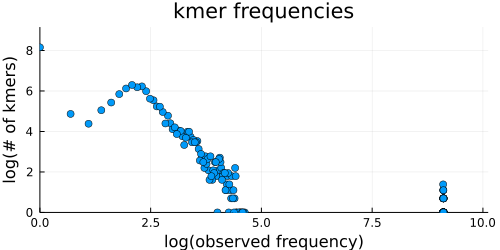

In [18]:
kmer_counts = Dict(observation_graph.vprops[v][:kmer] => observation_graph.vprops[v][:weight] for v in Graphs.vertices(observation_graph))
total_observed_kmers = sum(values(kmer_counts))
kmer_probabilities = Dict(k => v/total_observed_kmers for (k,v) in kmer_counts)
scale = 250
Mycelia.plot_kmer_frequency_spectra(values(kmer_counts), size=(2scale,scale), title="kmer frequencies")

In [19]:
reference_kmers = keys(Mycelia.count_canonical_kmers(BioSequences.DNAMer{k}, reference_fasta_file))
distance_to_reference_graph = 1 - LSHFunctions.jaccard(Set(reference_kmers), Set(keys(kmer_counts)))

0.9903609296347863

In [20]:
# step 1, hard-filter singletons

In [21]:
filtered_vertices = findall(v -> observation_graph.vprops[v][:weight] >= 5, Graphs.vertices(observation_graph))

5481-element Vector{Int64}:
    2
    4
    6
    9
   10
   13
   14
   16
   21
   25
   26
   29
   33
    ⋮
 9298
 9301
 9305
 9310
 9313
 9316
 9319
 9323
 9328
 9329
 9330
 9333

In [22]:
filtered_observation_graph, vertex_map = Graphs.induced_subgraph(observation_graph, filtered_vertices)

({5481, 12150} directed Int64 metagraph with Float64 weights defined by :weight (default weight 1.0), [2, 4, 6, 9, 10, 13, 14, 16, 21, 25  …  9305, 9310, 9313, 9316, 9319, 9323, 9328, 9329, 9330, 9333])

In [23]:
# visualize
gfa_file = observations_file * ".k-$k.filtered.gfa"
Mycelia.graph_to_gfa(filtered_observation_graph, gfa_file)

run(`$(BANDAGE) image $(gfa_file) $(gfa_file).svg --depwidth .9 --deppower .9`)
# --nodewidth <float> Average node width (0.5 to 1000, default: 5)
# --depwidth <float>  Depth effect on width (0 to 1, default: 0.5)
# --deppower <float>  Power of depth effect on width (0 to 1, default: 0.5)

html_path_to_svg = "./" * repeat("../", length(split(pwd(), '/')) - 3)
html_path_to_svg *= replace("$(gfa_file).svg", "$(homedir())/" => "")

x = "<img src=$(html_path_to_svg)>"
display("text/html", x)
# display("image/svg+xml", read("$(gfa_file).svg", String))

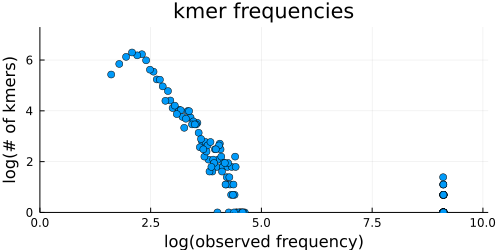

In [24]:
kmer_counts = Dict(filtered_observation_graph.vprops[v][:kmer] => filtered_observation_graph.vprops[v][:weight] for v in Graphs.vertices(filtered_observation_graph))
total_observed_kmers = sum(values(kmer_counts))
kmer_probabilities = Dict(k => v/total_observed_kmers for (k,v) in kmer_counts)
scale = 250
Mycelia.plot_kmer_frequency_spectra(values(kmer_counts), size=(2scale,scale), title="kmer frequencies")

In [25]:
distance_to_reference_graph = 1 - LSHFunctions.jaccard(Set(reference_kmers), Set(keys(kmer_counts)))

0.9835796387520526

In [26]:
# step 2, re-simulate reads as a means of error correction

In [27]:
kmers = [filtered_observation_graph.vprops[v][:kmer] for v in Graphs.vertices(filtered_observation_graph)]
kmer_weights = [filtered_observation_graph.vprops[v][:weight] for v in Graphs.vertices(filtered_observation_graph)]
kmer_probabilities = kmer_weights ./ sum(kmer_weights)

5481-element Vector{Float64}:
 1.4518180670940969e-5
 8.934265028271366e-6
 1.1167831285339206e-5
 4.4671325141356824e-5
 8.934265028271366e-6
 1.675174692800881e-5
 1.0051048156805286e-5
 1.5634963799474887e-5
 3.462027698455154e-5
 1.2284614413873126e-5
 4.802167452695859e-5
 1.2284614413873126e-5
 2.4569228827746253e-5
 ⋮
 1.3401397542407047e-5
 1.1167831285339206e-5
 2.010209631361057e-5
 1.5634963799474887e-5
 5.583915642669603e-6
 2.121887944214449e-5
 6.700698771203523e-6
 6.812377084056916e-5
 1.5634963799474887e-5
 2.6802795084814093e-5
 2.6802795084814093e-5
 7.59412527403066e-5

In [28]:
edge_weights = determine_edge_weights(filtered_observation_graph)

Dict{Bool, SparseArrays.SparseMatrixCSC{Float64, Int64}} with 2 entries:
  0 => …
  1 => …

In [29]:
edge_weights[true]

5481×5481 SparseArrays.SparseMatrixCSC{Float64, Int64} with 6081 stored entries:
⠉⠙⡒⢶⠦⠤⠤⠤⠤⣄⣀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⢠⣌⢊⢔⡆⡐⡲⠰⡈⢄⠈⠉⡋⠓⢲⠤⠤⣄⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠈⠀⢈⠩⠋⠀⢋⠀⠀⠊⠀⠀⠁⡁⠁⠌⠀⢈⡝⢉⣳⣦⣄⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠂⢘⡊⠋⠐⢐⠐⠰⡀⠀⠀⠐⡓⠒⠖⠁⠈⠇⣘⣹⠈⢟⠩⣏⣷⡶⢤⣤⣀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠂⢌⡠⠀⠐⠢⠐⡠⠐⢲⡗⣎⣧⢰⡇⠀⠀⠈⠁⠀⡀⠈⠁⢹⢊⡍⠠⠩⠙⠲⣄⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠄⠀⠀⠀⠀⠀⢰⣀⡀⢈⡓⢄⡆⢀⠄⠀⠀⠁⠠⠠⠹⢈⠄⣹⠷⠇⠬⠅⠄⠈⠂⠛⡲⣄⡀⠀⠀⠀
⠀⠀⠨⠈⠅⠠⢴⠠⡹⢭⠙⢌⣯⡻⢭⣚⠅⠀⠀⠸⠁⠀⠐⠨⠧⡴⡜⠅⡺⠖⠀⠈⡏⢰⢓⠟⣿⣶⡀⠀
⠀⠀⠀⠒⡁⠄⢸⠄⢉⣛⠈⢉⣣⢳⠫⡢⡇⠀⠀⠀⠰⡠⠒⡀⣃⡘⢖⡖⣒⠺⠂⠀⣯⣅⢸⣨⢿⡧⢳⣦
⠓⠢⠤⠤⣄⣀⣁⡀⠉⠉⠀⠁⠁⠁⠉⠉⠀⠀⠀⠀⠀⠀⠁⠀⠉⠀⠀⠉⠈⠀⠀⠀⠈⠁⠈⠈⠈⠀⠈⠉
⠀⠀⠀⠀⠐⢉⣉⢩⡙⠲⠤⣄⣀⣀⣀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠈⢾⡓⠚⠁⠀⠀⡂⠁⠀⠘⡫⠉⠉⠳⢤⣀⣀⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠘⠛⡑⡀⠈⡓⢂⡐⡀⠘⠠⠁⠀⠀⠀⠀⠀⣿⠟⠝⣓⣦⢤⢤⣀⣀⡀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠩⣽⣅⣀⣄⣡⢉⡧⣉⠸⠃⠀⠀⠀⠀⠀⠰⢡⣀⡼⣻⠍⡾⡟⠁⠉⠙⠦⠤⣤⡀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⢋⡎⠴⠽⠇⠖⠍⢸⠵⡄⠀⠀⠀⠀⠀⠀⢘⡟⠞⣊⠘⡎⣧⡅⠀⠀⠀⠸⡏⡟⣿⢲⡀
⠀⠀⠀⠀⠀⠀⠀⠘⠄⡂⠆⠇⢺⠎⣸⡘⠂⠀⠀⠀⠀⠀⠀⠠⣾⠯⠮⣭⣏⡽⠇⠀⠀⠀⠀⢳⣿⣾⠀⢹
⠉⠙⠒⠒⠲⠤⠤⢄⣀⣀⣀⣁⣀⡀⠈⠀⠀⠀⠀⠀⠀⠀⠀⠀⠁⠀⠁⠉⠉⠁⠀⠀⠀⠀⠀⠀⠈⠁⠀⠈
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠨⠀⢋⣉⠏⢿⠟⠒⠒⠦⠤⠤⣄⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢈⣽⠔⡒⣲⡂⠀⠀⠀⠀⠀⠀⠉⠉⢷⡶⠶⢦⣤⠤⣀⢀⣀⡀⠀⠀⠀⠀⠀
⢀⡀⠀⣀⣀⣀⠀⠀⠀⠀⠀⠀⢘⢿⠿⡷⠂⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⣭⣻⣿⠆⠀⠀⠀⠈⠉⣭⢛⠲⢤
⠀⠀⠀⠀⠀⠈⠉⠉⠉⠉⠉⠈⠁⠉⠹⣷⡖⠲⠤⠠⠤⠀⠄⠠⠤⠤⠤⠤⣄⣀⡀⠀⢀⠀⠀⠀⡀⠀⠀⡀

In [30]:
edge_weights = determine_edge_weights(filtered_observation_graph)
edge_probabilities = determine_edge_probabilities(edge_weights)

Dict{Bool, SparseArrays.SparseMatrixCSC{Float64, Int64}} with 2 entries:
  0 => …
  1 => …

In [31]:
kmers = [filtered_observation_graph.vprops[v][:kmer] for v in Graphs.vertices(filtered_observation_graph)]
kmer_weights = [filtered_observation_graph.vprops[v][:weight] for v in Graphs.vertices(filtered_observation_graph)]
kmer_probabilities = kmer_weights ./ sum(kmer_weights)

edge_weights = determine_edge_weights(filtered_observation_graph)
edge_probabilities = determine_edge_probabilities(edge_weights)

step_probabilities = deepcopy(edge_probabilities)

for orientation in [true, false]
#     @show orientation
    oriented_step_probabilities = step_probabilities[orientation] 
    for row in 1:size(step_probabilities[orientation], 1)
        step_probabilities_ = step_probabilities[orientation][row, :] .* kmer_probabilities
        if sum(step_probabilities_) > 0
            step_probabilities[orientation][row, :] .= step_probabilities_ ./ sum(step_probabilities_)
        end
    end
end

In [32]:
new_records = FASTX.FASTQ.Record[]
ProgressMeter.@showprogress for observation in observations
    read_length = length(FASTX.sequence(observation))
    max_steps = read_length - filtered_observation_graph.gprops[:k]
    # apply a squaring penalty to kmer_weights?
    initial_vertex = StatsBase.sample(1:length(kmers), StatsBase.weights(kmer_weights.^2))
#     @show "choosing initial vertex $initial_vertex with probability $(kmer_weights[initial_vertex])"
    initial_orientation = rand(Bool)
    forward_walk = random_walk(filtered_observation_graph, initial_vertex, initial_orientation, step_probabilities, n_steps=max_steps)
    remaining_steps = max_steps - length(forward_walk)
    reverse_walk = random_walk(filtered_observation_graph, initial_vertex, !initial_orientation, step_probabilities, n_steps = remaining_steps)
    full_walk = [[(vertex=x.vertex, orientation=!x.orientation) for x in reverse(reverse_walk)]..., [(vertex = initial_vertex, orientation = initial_orientation)]..., forward_walk...]
    oriented_path = [(x.vertex, x.orientation) for x in full_walk]
    new_seq = Mycelia.oriented_path_to_sequence(filtered_observation_graph, oriented_path)
    new_record = FASTX.FASTQ.Record(
        FASTX.identifier(observation)*"-k$k",
        FASTX.identifier(observation),
        new_seq,
        StatsBase.sample(FASTX.quality(observation), length(new_seq))
    )
#     @show "here"
    push!(new_records, new_record)
end
new_records;

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


In [33]:
corrected_fastq_file = replace(observations_file, r"\.fastq" => ".k$k.fastq")
open(corrected_fastq_file, "w") do io
    fastq_writer = FASTX.FASTQ.Writer(io)
    for record in new_records
        write(fastq_writer, record)
    end
    close(fastq_writer)
end

In [34]:
corrected_observation_graph = Mycelia.fastx_to_kmer_graph(BioSequences.DNAMer{k}, corrected_fastq_file)

┌ Info: assessing kmers
└ @ Mycelia /home/jovyan/git/Mycelia/src/Mycelia.jl:1932
┌ Info: creating graph
└ @ Mycelia /home/jovyan/git/Mycelia/src/Mycelia.jl:1948


{456, 972} directed Int64 metagraph with Float64 weights defined by :weight (default weight 1.0)

In [35]:
# visualize
gfa_file = corrected_fastq_file * ".k-$k.gfa"
Mycelia.graph_to_gfa(corrected_observation_graph, gfa_file)

run(`$(BANDAGE) image $(gfa_file) $(gfa_file).svg --depwidth .9 --deppower .9`)
# --nodewidth <float> Average node width (0.5 to 1000, default: 5)
# --depwidth <float>  Depth effect on width (0 to 1, default: 0.5)
# --deppower <float>  Power of depth effect on width (0 to 1, default: 0.5)

html_path_to_svg = "./" * repeat("../", length(split(pwd(), '/')) - 3)
html_path_to_svg *= replace("$(gfa_file).svg", "$(homedir())/" => "")

x = "<img src=$(html_path_to_svg)>"
display("text/html", x)
# display("image/svg+xml", read("$(gfa_file).svg", String))

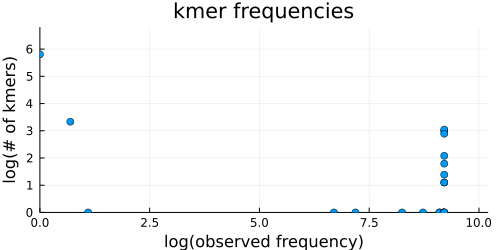

In [36]:
kmer_counts = Dict(corrected_observation_graph.vprops[v][:kmer] => corrected_observation_graph.vprops[v][:weight] for v in Graphs.vertices(corrected_observation_graph))
total_observed_kmers = sum(values(kmer_counts))
kmer_probabilities = Dict(k => v/total_observed_kmers for (k,v) in kmer_counts)
scale = 250
Mycelia.plot_kmer_frequency_spectra(values(kmer_counts), size=(2scale,scale), title="kmer frequencies")

In [37]:
# compare the new graph to the error-free graph to the error-corrected graph

In [38]:
reference_kmers = keys(Mycelia.count_canonical_kmers(BioSequences.DNAMer{k}, reference_fasta_file))
distance_to_reference_graph = 1 - LSHFunctions.jaccard(Set(reference_kmers), Set(keys(kmer_counts)))

0.8026315789473684

# another round

In [39]:
k_index += 1
k = k_options[k_index]
@show k

k = 13


13

In [40]:
observation_graph = corrected_observation_graph
observations_file = corrected_fastq_file

"/home/jovyan/2021-08-23/LENGTH-100-DEPTH-10000.k11.fastq"

In [41]:
# step 1, hard-filter singletons

In [42]:
filtered_vertices = findall(v -> observation_graph.vprops[v][:weight] >= 5, Graphs.vertices(observation_graph))

94-element Vector{Int64}:
   5
  12
  20
  24
  30
  33
  36
  42
  44
  51
  52
  56
  58
   ⋮
 388
 389
 396
 400
 412
 413
 420
 428
 431
 433
 444
 453

In [43]:
filtered_observation_graph, vertex_map = Graphs.induced_subgraph(observation_graph, filtered_vertices)

({94, 186} directed Int64 metagraph with Float64 weights defined by :weight (default weight 1.0), [5, 12, 20, 24, 30, 33, 36, 42, 44, 51  …  396, 400, 412, 413, 420, 428, 431, 433, 444, 453])

In [44]:
# visualize
gfa_file = observations_file * ".k-$k.filtered.gfa"
Mycelia.graph_to_gfa(filtered_observation_graph, gfa_file)

run(`$(BANDAGE) image $(gfa_file) $(gfa_file).svg --depwidth .9 --deppower .9`)
# --nodewidth <float> Average node width (0.5 to 1000, default: 5)
# --depwidth <float>  Depth effect on width (0 to 1, default: 0.5)
# --deppower <float>  Power of depth effect on width (0 to 1, default: 0.5)

html_path_to_svg = "./" * repeat("../", length(split(pwd(), '/')) - 3)
html_path_to_svg *= replace("$(gfa_file).svg", "$(homedir())/" => "")

x = "<img src=$(html_path_to_svg)>"
display("text/html", x)
# display("image/svg+xml", read("$(gfa_file).svg", String))

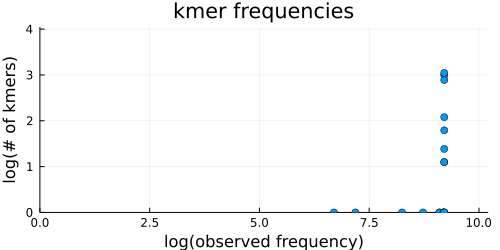

In [45]:
kmer_counts = Dict(filtered_observation_graph.vprops[v][:kmer] => filtered_observation_graph.vprops[v][:weight] for v in Graphs.vertices(filtered_observation_graph))
total_observed_kmers = sum(values(kmer_counts))
kmer_probabilities = Dict(k => v/total_observed_kmers for (k,v) in kmer_counts)
scale = 250
Mycelia.plot_kmer_frequency_spectra(values(kmer_counts), size=(2scale,scale), title="kmer frequencies")

In [46]:
distance_to_reference_graph = 1 - LSHFunctions.jaccard(Set(reference_kmers), Set(keys(kmer_counts)))
@show length(Set(reference_kmers))
@show length(Set(keys(kmer_counts)))
@show distance_to_reference_graph;

length(Set(reference_kmers)) = 90
length(Set(keys(kmer_counts))) = 94
distance_to_reference_graph = 0.04255319148936165


In [47]:
# step 2, re-simulate reads as a means of error correction

In [48]:
kmers = [filtered_observation_graph.vprops[v][:kmer] for v in Graphs.vertices(filtered_observation_graph)]
kmer_weights = [filtered_observation_graph.vprops[v][:weight] for v in Graphs.vertices(filtered_observation_graph)]
kmer_probabilities = kmer_weights ./ sum(kmer_weights)

94-element Vector{Float64}:
 0.010991911695156476
 0.010991911695156476
 0.01099301154623664
 0.01099301154623664
 0.01099301154623664
 0.010996311099477131
 0.010994111397316804
 0.010991911695156476
 0.01099301154623664
 0.010995211248396967
 0.010997410950557295
 0.010994111397316804
 0.010995211248396967
 ⋮
 0.006776182504888838
 0.010991911695156476
 0.01099301154623664
 0.010995211248396967
 0.009861264784748145
 0.010994111397316804
 0.01099301154623664
 0.010994111397316804
 0.01099301154623664
 0.010991911695156476
 0.010991911695156476
 0.0008908793749326341

In [49]:
edge_weights = determine_edge_weights(filtered_observation_graph)

Dict{Bool, SparseArrays.SparseMatrixCSC{Float64, Int64}} with 2 entries:
  0 => …
  1 => …

In [50]:
edge_weights[true]

94×94 SparseArrays.SparseMatrixCSC{Float64, Int64} with 93 stored entries:
⠀⠈⠀⠐⠀⠀⠀⠀⠀⠠⠀⡀⠀⢀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⢀⠀⠀⠀⠀⠀⠁⠀⠀⠀⠀⠀⠀⠀⠀⠐⠀⠀⠄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⠉⠐⠄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠐⠀⠀⠀⠠⠠⠀⢀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠰⠀⠀⠀⠀⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠁⡀⠀⠀⠀⠀⠀⠀⠀⠰⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠐⠂⠀⠀⠀⠀⠠⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⠀⠀⠀⠀⠀⠀⠁⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠄⠀⠀⠂⠀⠀⢀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠀
⡀⠀⠀⠀⠀⠀⠀⠀⠀⠠⠀⠀⠀⠀⠀⠐⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠀⠀⠀⠀⠀
⠀⠈⠀⠀⠀⠀⠀⠂⠐⠄⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠐⠀⠀⠀⠀⠀⠀⠀⠀⠈⠀⠀⠀⠠⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠁⠀⠀⠀⠂⠄⠀⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠐⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠀⢀⠀⠈⠀⠠⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠁⠠⠀⠀⠀⢀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠐⠀⠄⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠄⠈⠂⠀⠀⠀⠀⡀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠐⠀⠀⡀⠁⠀⠀⠀⠀⠀⠀⠀⠀⠄⠀
⠀⠂⠂⠀⠠⠀⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠂⠈⠀⠀⠀⠀⠀⢀⠀⢀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠨⠀⠀⠀⠀⠀⠂⠀⠀⡀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠂⠠⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠁⢀⠀⠀⠁⠀⠀⠀⠀⠀⠀⠀⠀

In [51]:
edge_weights = determine_edge_weights(filtered_observation_graph)
edge_probabilities = determine_edge_probabilities(edge_weights)

Dict{Bool, SparseArrays.SparseMatrixCSC{Float64, Int64}} with 2 entries:
  0 => …
  1 => …

In [52]:
kmers = [filtered_observation_graph.vprops[v][:kmer] for v in Graphs.vertices(filtered_observation_graph)]
kmer_weights = [filtered_observation_graph.vprops[v][:weight] for v in Graphs.vertices(filtered_observation_graph)]
kmer_probabilities = kmer_weights ./ sum(kmer_weights)

edge_weights = determine_edge_weights(filtered_observation_graph)
edge_probabilities = determine_edge_probabilities(edge_weights)

step_probabilities = deepcopy(edge_probabilities)

for orientation in [true, false]
#     @show orientation
    oriented_step_probabilities = step_probabilities[orientation] 
    for row in 1:size(step_probabilities[orientation], 1)
        step_probabilities_ = step_probabilities[orientation][row, :] .* kmer_probabilities
        if sum(step_probabilities_) > 0
            step_probabilities[orientation][row, :] .= step_probabilities_ ./ sum(step_probabilities_)
        end
    end
end

In [53]:
new_records = FASTX.FASTQ.Record[]
ProgressMeter.@showprogress for observation in observations
    read_length = length(FASTX.sequence(observation))
    max_steps = read_length - filtered_observation_graph.gprops[:k]
    # apply a squaring penalty to kmer_weights?
    initial_vertex = StatsBase.sample(1:length(kmers), StatsBase.weights(kmer_weights.^2))
#     @show "choosing initial vertex $initial_vertex with probability $(kmer_weights[initial_vertex])"
    initial_orientation = rand(Bool)
    forward_walk = random_walk(filtered_observation_graph, initial_vertex, initial_orientation, step_probabilities, n_steps=max_steps)
    remaining_steps = max_steps - length(forward_walk)
    reverse_walk = random_walk(filtered_observation_graph, initial_vertex, !initial_orientation, step_probabilities, n_steps = remaining_steps)
    full_walk = [[(vertex=x.vertex, orientation=!x.orientation) for x in reverse(reverse_walk)]..., [(vertex = initial_vertex, orientation = initial_orientation)]..., forward_walk...]
    oriented_path = [(x.vertex, x.orientation) for x in full_walk]
    new_seq = Mycelia.oriented_path_to_sequence(filtered_observation_graph, oriented_path)
    new_record = FASTX.FASTQ.Record(
        FASTX.identifier(observation)*"-k$k",
        FASTX.identifier(observation),
        new_seq,
        StatsBase.sample(FASTX.quality(observation), length(new_seq))
    )
#     @show "here"
    push!(new_records, new_record)
end
new_records;

Progress: 100%|█████████████████████████████████████████| Time: 0:00:05


In [54]:
corrected_fastq_file = replace(observations_file, r"\.fastq" => ".k$k.fastq")
open(corrected_fastq_file, "w") do io
    fastq_writer = FASTX.FASTQ.Writer(io)
    for record in new_records
        write(fastq_writer, record)
    end
    close(fastq_writer)
end

In [55]:
corrected_observation_graph = Mycelia.fastx_to_kmer_graph(BioSequences.DNAMer{k}, corrected_fastq_file)

┌ Info: assessing kmers
└ @ Mycelia /home/jovyan/git/Mycelia/src/Mycelia.jl:1932
┌ Info: creating graph
└ @ Mycelia /home/jovyan/git/Mycelia/src/Mycelia.jl:1948


{92, 182} directed Int64 metagraph with Float64 weights defined by :weight (default weight 1.0)

In [56]:
# visualize
gfa_file = corrected_fastq_file * ".k-$k.gfa"
Mycelia.graph_to_gfa(corrected_observation_graph, gfa_file)

run(`$(BANDAGE) image $(gfa_file) $(gfa_file).svg --depwidth .9 --deppower .9`)
# --nodewidth <float> Average node width (0.5 to 1000, default: 5)
# --depwidth <float>  Depth effect on width (0 to 1, default: 0.5)
# --deppower <float>  Power of depth effect on width (0 to 1, default: 0.5)

html_path_to_svg = "./" * repeat("../", length(split(pwd(), '/')) - 3)
html_path_to_svg *= replace("$(gfa_file).svg", "$(homedir())/" => "")

x = "<img src=$(html_path_to_svg)>"
display("text/html", x)
# display("image/svg+xml", read("$(gfa_file).svg", String))

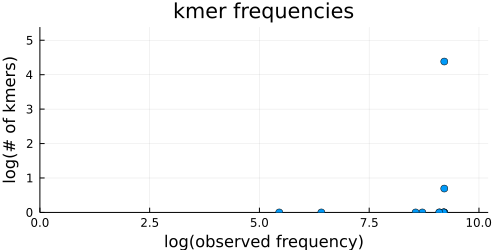

In [57]:
kmer_counts = Dict(corrected_observation_graph.vprops[v][:kmer] => corrected_observation_graph.vprops[v][:weight] for v in Graphs.vertices(corrected_observation_graph))
total_observed_kmers = sum(values(kmer_counts))
kmer_probabilities = Dict(k => v/total_observed_kmers for (k,v) in kmer_counts)
scale = 250
Mycelia.plot_kmer_frequency_spectra(values(kmer_counts), size=(2scale,scale), title="kmer frequencies")

In [58]:
# compare the new graph to the error-free graph to the error-corrected graph

In [59]:
reference_kmers = keys(Mycelia.count_canonical_kmers(BioSequences.DNAMer{k}, reference_fasta_file))
distance_to_reference_graph = 1 - LSHFunctions.jaccard(Set(reference_kmers), Set(keys(kmer_counts)))
@show length(Set(reference_kmers))
@show length(Set(keys(kmer_counts)))
@show distance_to_reference_graph;

length(Set(reference_kmers)) = 88
length(Set(keys(kmer_counts))) = 92
distance_to_reference_graph = 0.04347826086956519


# Final polish and reduction

In [60]:
# to_filter = Int[]
connected_component = first(Graphs.connected_components(corrected_observation_graph))

92-element Vector{Int64}:
  1
  2
  3
  4
  5
  6
  7
  8
  9
 10
 11
 12
 13
  ⋮
 81
 82
 83
 84
 85
 86
 87
 88
 89
 90
 91
 92

In [61]:
tip_vertices = filter(v -> Graphs.degree(corrected_observation_graph, v) == 2, Graphs.vertices(corrected_observation_graph))

4-element Vector{Int64}:
 18
 60
 65
 77

In [62]:
component_weights = map(v -> corrected_observation_graph.vprops[v][:weight], connected_component)

92-element Vector{Int64}:
 10000
 10000
 10000
 10000
 10000
 10000
 10000
 10000
 10000
 10000
 10000
 10000
 10000
     ⋮
 10000
 10000
 10000
 10000
 10000
 10000
 10000
 10000
  9847
  8989
 10000
 10000

In [63]:
component_median = Statistics.median(component_weights)

10000.0

In [64]:
component_standard_deviation = Statistics.std(component_weights)

1534.6343418504662

In [67]:
tips_to_drop = filter(tip -> corrected_observation_graph.vprops[tip][:weight] < component_median - 2*component_standard_deviation, tip_vertices) 

4-element Vector{Int64}:
 18
 60
 65
 77

In [68]:
polished_graph, vertex_map = Graphs.induced_subgraph(corrected_observation_graph, setdiff(Graphs.vertices(corrected_observation_graph), tips_to_drop))

({88, 174} directed Int64 metagraph with Float64 weights defined by :weight (default weight 1.0), [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  83, 84, 85, 86, 87, 88, 89, 90, 91, 92])

In [70]:
simplified_graph = Mycelia.simplify_kmer_graph(polished_graph)

┌ Info: simplifying kmer graph
└ @ Mycelia /home/jovyan/git/Mycelia/src/Mycelia.jl:2260
┌ Info: resolving untigs...
└ @ Mycelia /home/jovyan/git/Mycelia/src/Mycelia.jl:2261


  0.435701 seconds (369.19 k allocations: 22.173 MiB, 98.55% compilation time)


┌ Info: determining untig orientations...
└ @ Mycelia /home/jovyan/git/Mycelia/src/Mycelia.jl:2264


  0.203587 seconds (189.29 k allocations: 11.308 MiB, 98.54% compilation time)


┌ Info: initializing graph node metadata
└ @ Mycelia /home/jovyan/git/Mycelia/src/Mycelia.jl:2269
┌ Info: creating simplified unitgs to help resolve connections
└ @ Mycelia /home/jovyan/git/Mycelia/src/Mycelia.jl:2279


{1, 0} directed Int64 metagraph with Float64 weights defined by :weight (default weight 1.0)

In [71]:
# write simplified graph to gfa

# visualize
gfa_file = corrected_fastq_file * ".k-$k.simplified.gfa"
Mycelia.graph_to_gfa(simplified_graph, gfa_file)

run(`$(BANDAGE) image $(gfa_file) $(gfa_file).svg --depwidth .9 --deppower .9`)
# --nodewidth <float> Average node width (0.5 to 1000, default: 5)
# --depwidth <float>  Depth effect on width (0 to 1, default: 0.5)
# --deppower <float>  Power of depth effect on width (0 to 1, default: 0.5)

html_path_to_svg = "./" * repeat("../", length(split(pwd(), '/')) - 3)
html_path_to_svg *= replace("$(gfa_file).svg", "$(homedir())/" => "")

x = "<img src=$(html_path_to_svg)>"
display("text/html", x)
# display("image/svg+xml", read("$(gfa_file).svg", String))

In [80]:
simplified_graph.vprops[1][:weight]

10000.0

In [75]:
vertex = 1
FASTX.FASTA.Record(
    ,
    "DEPTH=$()",
    simplified_graph.vprops[vertex][:sequence])

100nt DNA Sequence:
CTCACTGCAAAGCGCCCAGACCAGAGCCTCACCTACAAG…TGTACTATCTTCTCGAATACCAGCCGTCGGCCGGTATAA

In [77]:
FASTX.sequence(fasta_record) == simplified_graph.vprops[1][:sequence]

true

# !! EXACTLY THE SAME!!!

In [83]:
# write contigs to fasta
final_fasta_file = corrected_fastq_file * ".k-$k.simplified.fasta"
open(final_fasta_file, "w") do io
    fasta_io = FASTX.FASTA.Writer(io)
    for vertex in Graphs.vertices(simplified_graph)
        seq = simplified_graph.vprops[vertex][:sequence]
        description = string(simplified_graph.vprops[vertex][:weight])
        id = string(hash(seq)) * '-' * string(Dates.now())
        record = FASTX.FASTA.Record(id, description, seq)
        @show record
        write(fasta_io, record)
    end
    close(fasta_io)
end

record = FASTX.FASTA.Record:
   identifier: 3157291459485254640-2021-08-23T23:41:50.685
  description: 10000.0
     sequence: CTCACTGCAAAGCGCCCAGACCAGAGCCTCACCTACAAG…
